In [87]:
import os
os.chdir("C://Users//lorenz.hering//Desktop//BE//02_Schulungen//Data Analyst Nanodegree//06 Intro to Machine Learning//ud120-projects-master//final_project")
os.getcwd()

'C:\\Users\\lorenz.hering\\Desktop\\BE\\02_Schulungen\\Data Analyst Nanodegree\\06 Intro to Machine Learning\\ud120-projects-master\\final_project'

In [88]:
os.listdir()

['emails_by_address',
 'enron61702insiderpay.pdf',
 'final_project_dataset.pkl',
 'final_project_dataset_modified.pkl',
 'poi_email_addresses.py',
 'poi_id.py',
 'poi_names.txt',
 'tester.py']

The enron dataset contains email (emails written) and financial data (salary, bonus etc.) from enron employees. 

The goal of this project is to find out what features identify a person of interest (POI). For this purpose we can apply machine learning to train a model on a dataset with these features. Based on these features the algorithmn can tell us if a specific person is a POI or not.

In [173]:
#!/usr/bin/python

import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV

from feature_format import featureFormat, targetFeatureSplit

### Select features
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'bonus', 'salary', 'fraction_from_poi_email', 'fraction_to_poi_email', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [169]:
### get to know the data
print (len(data_dict.keys()))
print (data_dict['BUY RICHARD B'])

146
{'salary': 330546, 'to_messages': 3523, 'deferral_payments': 649584, 'total_payments': 2355702, 'loan_advances': 'NaN', 'bonus': 900000, 'email_address': 'rick.buy@enron.com', 'restricted_stock_deferred': 'NaN', 'deferred_income': -694862, 'total_stock_value': 3444470, 'expenses': 'NaN', 'from_poi_to_this_person': 156, 'exercised_stock_options': 2542813, 'from_messages': 1053, 'other': 400572, 'from_this_person_to_poi': 71, 'poi': False, 'long_term_incentive': 769862, 'shared_receipt_with_poi': 2333, 'restricted_stock': 901657, 'director_fees': 'NaN'}


Now that we got a feel for the dataset, lets visualize the data and check for outliers, especially when plotting salary and bonus.

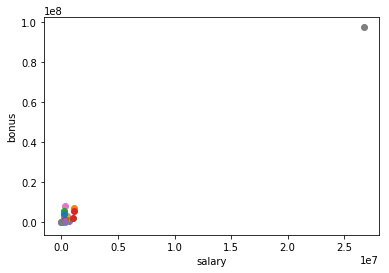

In [174]:
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

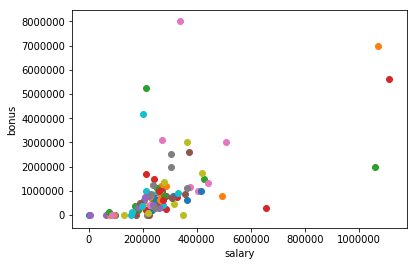

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321)]


In [175]:
### remove outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

### plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

from pprint import pprint

outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key,int(val)))

pprint(sorted(outliers,key=lambda x:x[1],reverse=True)[:2])

After removing the outlier, the plot shows a better picture. We still have some data points with very high x and y values, but this seems ok for C-level positions and possibly POIs.

We already have the features bonus and salary. It is quite possible that POI have relatively high bonus and salary numbers. However, lets create some new features. POIs possible wrote a lot of emails back and forth. Therefore, we define the features fraction_to_poi_email and fraction_from_poi_email.

In [176]:
### create new features
### new features: fraction_to_poi_email, fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

### store to my_dataset for easy export below
my_dataset = data_dict

### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


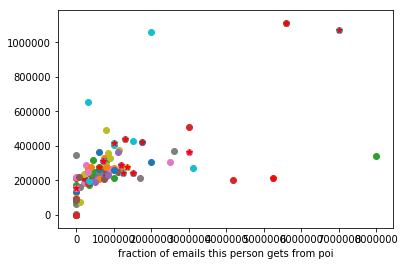

In [177]:
### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

In [178]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In this section we will apply machine learning. Specifically, I will first split my data into training and testing data. In machine learning this is common practics to avoid overfitting. 

When using the k-fold cross validation method, the training set is split into k smaller sets. A model is trained using k-1 of the folds as training data; the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.

Now that we have split the data, can can apply an algorithmn. I first applied the decision tree classifier. Decision trees ask multiple linear questions, one after another. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [204]:
### ML goes here!

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)

### Accuracy before tuning
print (score)

### Decision tree algorithm time
print (round(time()-t0, 3), "s")

0.837837837838
0.003 s


In [202]:
importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]

for i in range(5):
    print ("{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]]))

1 feature bonus (0.37837899543379006)
2 feature salary (0.2776255707762557)
3 feature fraction_from_poi_email (0.1804566210045662)
4 feature fraction_to_poi_email (0.16353881278538807)
5 feature shared_receipt_with_poi (0.0)


I first started with the default parameters and got an accuracy score of 83.8% after 0.003s.
I ranked the feature importance. Bonus seems to be the feature of highest importance when identifying POIs (followed by salary). However, our self-build features also seem to have an influence.

After that I tried a naive bayes classifier. This algorithmn did not perform as good as the decision tree (slower). Therefore, I commented it out.

In [207]:
### try Naive Bayes for prediction

#t0 = time()

#clf = GaussianNB()
#clf.fit(features_train, labels_train)
#pred = clf.predict(features_test)
#accuracy = accuracy_score(pred,labels_test)

### Accuracy NB
#print (accuracy)

### NB algorithm time
#print (round(time()-t0, 3), "s")

In [208]:
### use manual tuning parameter min_samples_split
### Tune classifier to achieve better than .3 precision and recall 

t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)

print("done in %0.3fs" % (time() - t0))

acc = accuracy_score(labels_test, pred)

print ("Validating algorithm:")
print ("accuracy after tuning = ", acc)

# function for calculation ratio of true positives
# out of all positives (true + false)
print ('precision = ', precision_score(labels_test,pred))

# function for calculation ratio of true positives
# out of true positives and false negatives
print ('recall = ', recall_score(labels_test,pred))

done in 0.001s
Validating algorithm:
accuracy after tuning =  0.864864864865
precision =  0.5
recall =  0.4


Finally, I decided to do some manual tuning to my classifier to achieve better than .3 precision and recall.

I chose a min samples split of 5, which is the minimum number of samples required to split an internal node. This can avoid overfitting.

My accuracy after tuning is with 86.5% slightly higher than before.

Additionally, I calculated the precision and recall ratios.

Where precision measures the ratio of true positives (meaning a real POI is also predicted to be a POI) out of true positives plus false positives.
A high precision states that nearly every time a POI shows up in my test set, I am able to identify him or her.

And recall measures the ratio of true positives in relation to true positives and false negatives.
A high recall rate states that I am good at NOT falsely predicting POIs.

With a precision of 0.5 and a recall of 0.4 my classifier beats the .3 both times. yay!

In [159]:
### dump your classifier, dataset and features_list so
### anyone can run/check your results

pickle.dump(clf, open("my_classifier.pkl", "wb") )
pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
pickle.dump(features_list, open("my_feature_list.pkl", "wb") )